importing the required packages:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


reading the dataset and storing it in a Pandas dataframe:

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/files/train_sample.csv')
df

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,89489,3,1,13,379,2017-11-06 15:13:23,NaN,0
1,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1
2,3437,6,1,13,459,2017-11-06 15:42:32,NaN,0
3,167543,3,1,13,379,2017-11-06 15:56:17,NaN,0
4,147509,3,1,13,379,2017-11-06 15:57:01,NaN,0
...,...,...,...,...,...,...,...,...
2300556,32457,2,1,19,477,2017-11-09 15:59:59,NaN,0
2300557,20266,14,1,13,446,2017-11-09 15:59:59,NaN,0
2300558,49383,12,2,17,178,2017-11-09 16:00:00,NaN,0
2300559,34894,12,1,15,145,2017-11-09 16:00:00,NaN,0


### EDA

checking information of the dataframe:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300561 entries, 0 to 2300560
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   ip               int64 
 1   app              int64 
 2   device           int64 
 3   os               int64 
 4   channel          int64 
 5   click_time       object
 6   attributed_time  object
 7   is_attributed    int64 
dtypes: int64(6), object(2)
memory usage: 140.4+ MB


checking to see if there are any Nan values in the dataframe:

In [ ]:
df.isna().sum()

ip                       0
app                      0
device                   0
os                       0
channel                  0
click_time               0
attributed_time    1843715
is_attributed            0
dtype: int64

only "attributed_time" column has Nan values. Let's check the target column:

In [ ]:
# how many instances per value in "is_attributed" column
df['is_attributed'].value_counts()

0    1843715
1     456846
Name: is_attributed, dtype: int64

the number of Nans in the "attributed_time" column is equal to number of rows with 0 value in their target column. this is because there is no attributed_time for people who didn't do the downloading. so, Nan values aren't missing information here, it's just a nonexisting parameter for some rows. we'll deal with this later.

let's check the distribution of the target column:

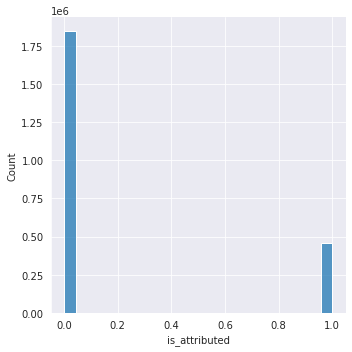

In [ ]:
sns.set_style('darkgrid')
sns.displot(df['is_attributed'])

so, it seems that there are way more instances that didn't download the app and the dataset is imbalanced. we should consider this issue later on.

printing the unique values and total number of unique values per column:

In [ ]:
for i in df.columns:
    print(i, df[i].unique(), df[i].nunique())
    print()

ip [ 89489 204158   3437 ... 313982 331467  60996] 260238

app [  3  35   6  15  14   2   1  64  20  22  12   9 110  27  88  17  19  21
  72  11  18  26  29 128   8  13  45  10  25  23  28 155  78 136 151  96
   5  32 150  36 251  24  85 303  50 167 347  39 115  84 261 125  34 105
  37  51  66 121 108  71  57  82  60  52  80 190 120  79 122 148  48 107
 127  65  16 215 145 103  99 172 152 175   0 210 154 208 265 170 279  83
 481 183 202 231 233 230  86  40 236 143 118   4 361 158 223  81 192  55
  95  58 538 130  38 250 166 246  74  91  98 119 256  46 216 484 141  53
 551  56 244 109 162 207 383 112 188 197 232 395  33 255 185  76 195 181
 436 206 326 333  89 292 173 114 266 241  47 525 536  54 146  68 320 134
  59 315 177 386 165 133  49 224 237 163 283  62 242 102  42 363  93 443
 240 381 557  94 268 100 203 137 176 160 153  43 124 537 419 346 194 196
 116 142 182 101  97 358  87  61 534 258 364  31  90 111 272 123 149 319
 336 174 267 171 394 615 304 252 541 161   7 559 322 535 379 

here we find out that there are plenty of unique values in feature columns. also they are not of the same scale; there is a wide range of numbers from single digit numbers to thousands in these columns. "click_time" and "attributed_time" have string values which should be handled.

### preprocessing

first, let's convert "click_time" from string to datetime format:

In [ ]:
df['click_time'] = pd.to_datetime(df['click_time'], format='%Y-%m-%d %H:%M:%S')

now separate each part of datetime and put it in a separate column and add it to dataframe: <br>
I ignored minute and second because they are too much of detail and differing in a minute or second doesn't play a role in downloading an app.

In [ ]:
df['year'] = [d.date().year for d in df['click_time']]  # year
df['month'] = [d.date().month for d in df['click_time']]  # month
df['day'] = [d.date().day for d in df['click_time']]   # day
df['hour'] = [d.time().hour for d in df['click_time']]  # hour

In [ ]:
df

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,year,month,day,hour
0,89489,3,1,13,379,2017-11-06 15:13:23,NaN,0,2017,11,6,15
1,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,2017,11,6,15
2,3437,6,1,13,459,2017-11-06 15:42:32,NaN,0,2017,11,6,15
3,167543,3,1,13,379,2017-11-06 15:56:17,NaN,0,2017,11,6,15
4,147509,3,1,13,379,2017-11-06 15:57:01,NaN,0,2017,11,6,15
...,...,...,...,...,...,...,...,...,...,...,...,...
2300556,32457,2,1,19,477,2017-11-09 15:59:59,NaN,0,2017,11,9,15
2300557,20266,14,1,13,446,2017-11-09 15:59:59,NaN,0,2017,11,9,15
2300558,49383,12,2,17,178,2017-11-09 16:00:00,NaN,0,2017,11,9,16
2300559,34894,12,1,15,145,2017-11-09 16:00:00,NaN,0,2017,11,9,16


playing around with columns, I realized that there is only one value in "year" and "month" columns, so they are considered constants and I'll eliminate them later on. <br>
on the other hand, "day" and "hour" consist of various values and by plotting them against target column I realized that they do result in different target values. so, we'll keep them.

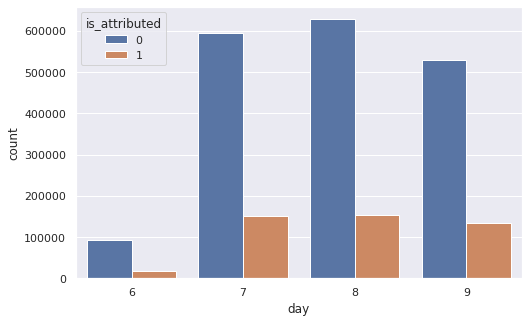

In [ ]:
sns.set(rc = {'figure.figsize':(8,5)})
sns.countplot(x='day', data=df, hue='is_attributed')

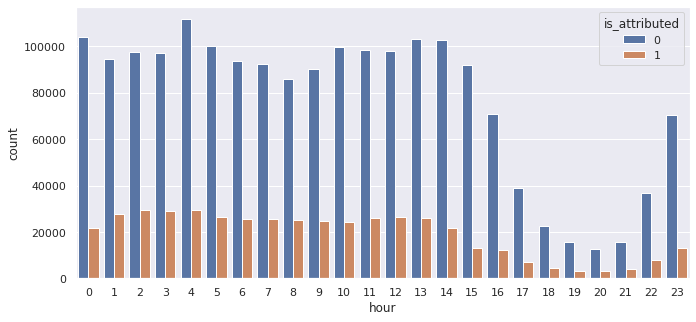

In [ ]:
sns.set(rc = {'figure.figsize':(11,5)})
sns.countplot(x='hour', data=df, hue='is_attributed')

In [ ]:
# unique values in year
df['year'].unique()

array([2017])

In [ ]:
# unique values in month
df['month'].unique()

array([11])

dropping useless columns: <br>
I explained the reason of eliminating "year" and "month". <br>
I'll also drop "click_time" because it's string and I already extracted its data. <br>
talking about "attributed_time" it doesn't provide any further information. it only shows the time of download for people who downloaded the app. it doesn't help in predicting whether someone will download the app or not, so I'll delete that too!

In [ ]:
df.drop(['click_time', 'attributed_time', 'year', 'month'], axis=1, inplace=True)

this is how the dataframe looks like:

In [ ]:
df

,ip,app,device,os,channel,is_attributed,day,hour
0,89489,3,1,13,379,0,6,15
1,204158,35,1,13,21,1,6,15
2,3437,6,1,13,459,0,6,15
3,167543,3,1,13,379,0,6,15
4,147509,3,1,13,379,0,6,15
...,...,...,...,...,...,...,...,...
2300556,32457,2,1,19,477,0,9,15
2300557,20266,14,1,13,446,0,9,15
2300558,49383,12,2,17,178,0,9,16
2300559,34894,12,1,15,145,0,9,16


now I want to find out 3 features that influence the target column the most:

In [ ]:
#apply SelectKBest class to extract top 3 best features
bestfeatures = SelectKBest(score_func=chi2, k=3)
fit = bestfeatures.fit(df.drop('is_attributed', axis=1), df['is_attributed'])

In [ ]:
# make a dataframe out of SelectKBest scores
dfscores = pd.DataFrame(fit.scores_)

# make a dataframe out of the main dataframe's columns
dfcolumns = pd.DataFrame(df.columns)

# concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores], axis=1)
featureScores.columns = ['Feature','Score']  # naming the dataframe columns
print(featureScores.nlargest(3,'Score'))  # print 3 best features

   Feature         Score
0       ip  1.974350e+10
1      app  7.485913e+06
4  channel  5.674188e+06


so, "ip" , "app" and "channel" have the most impact on target column, respectively.

main dataframe is really large and has about 2 million rows. so I decided to randomly pick 8000 rows and do the rest of analysis on this sampled dataset:

In [ ]:
df = df.sample(n=8000, axis=0, random_state=100)

the sampled dataframe:

In [ ]:
df.reset_index(inplace=True, drop=True)
df

,ip,app,device,os,channel,is_attributed,day,hour
0,57891,15,1,13,153,0,9,13
1,118458,12,1,13,265,0,8,9
2,31731,9,2,7,107,0,9,11
3,84395,2,1,6,452,0,9,10
4,332265,5,1,37,113,1,9,14
...,...,...,...,...,...,...,...,...
7995,2095,64,1,6,459,0,8,8
7996,15333,3,1,10,280,0,8,9
7997,49011,3,1,53,424,0,9,14
7998,102065,13,1,18,469,0,7,21


splitting the dataframe into train set and test set; 20% for test set and 80% for train set:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('is_attributed', axis=1), df['is_attributed'], test_size=0.2, random_state=100)

here, since the dataset is imbalanced, I used SMOTE on train set to oversample class 1 and undersample class 0, so that the process of training the models isn't biased towards the 0 class:

In [ ]:
sm = SMOTE(random_state=101)
# X_res and y_res are the new resampled train set
X_res, y_res = sm.fit_resample(X_train, y_train)

as mentioned earlier, feature columns of the dataset are not of the same scale. using a StandardScaler object I scaled the values of X_res and used the same object to transform X_test:

In [ ]:
scaler = StandardScaler()

In [ ]:
X_res = scaler.fit_transform(X_res)

In [ ]:
X_test = scaler.transform(X_test)

finally, splitting X_res and y_res; 70% for train set and 30% for validation set:

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.3, random_state=100)

In [ ]:
# checking shape of all matrices
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(7205, 7)
(7205,)
(3089, 7)
(3089,)
(1600, 7)
(1600,)


### models

#### 1- Logistic Regression

##### cross validation

using GridSearchCV with validation set to find better values for some of the main parameters of the model:

In [ ]:
# experimenting some values for parameters "C" and "max_iter" of logistic regression
lr_params = {'C': [0.01, 0.1, 1, 10, 100, 1000], 'max_iter': [50, 100, 200]}

In [ ]:
lr_grid = GridSearchCV(LogisticRegression(), lr_params, refit=True, verbose=5)

In [ ]:
lr_grid.fit(X_val, y_val)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END ...............C=0.01, max_iter=50;, score=0.777 total time=   0.0s
[CV 2/5] END ...............C=0.01, max_iter=50;, score=0.764 total time=   0.0s
[CV 3/5] END ...............C=0.01, max_iter=50;, score=0.807 total time=   0.0s
[CV 4/5] END ...............C=0.01, max_iter=50;, score=0.812 total time=   0.0s
[CV 5/5] END ...............C=0.01, max_iter=50;, score=0.789 total time=   0.0s
[CV 1/5] END ..............C=0.01, max_iter=100;, score=0.777 total time=   0.0s
[CV 2/5] END ..............C=0.01, max_iter=100;, score=0.764 total time=   0.0s
[CV 3/5] END ..............C=0.01, max_iter=100;, score=0.807 total time=   0.0s
[CV 4/5] END ..............C=0.01, max_iter=100;, score=0.812 total time=   0.0s
[CV 5/5] END ..............C=0.01, max_iter=100;, score=0.789 total time=   0.0s
[CV 1/5] END ..............C=0.01, max_iter=200;, score=0.777 total time=   0.0s
[CV 2/5] END ..............C=0.01, max_iter=200;

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [50, 100, 200]},
             verbose=5)

printing the best parameters found:

In [ ]:
lr_grid.best_params_

{'C': 10, 'max_iter': 50}

##### the model

training the logistic regression model on train set with the best parameters found:

In [ ]:
log_reg = LogisticRegression(C=10, max_iter=50)
log_reg.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=50)

predicting labels for train set in order to find out accuracy on train set:

In [ ]:
train_preds = log_reg.predict(X_train)

printing classification report and confusion matrix and accuracy score for prediction on train set:

In [ ]:
print(classification_report(y_train, train_preds))
print()
print(confusion_matrix(y_train, train_preds))
print()
print('logistic regression train accuracy :', round(accuracy_score(y_train, train_preds), 2))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81      3583
           1       0.81      0.79      0.80      3622

    accuracy                           0.80      7205
   macro avg       0.80      0.80      0.80      7205
weighted avg       0.80      0.80      0.80      7205


[[2930  653]
 [ 764 2858]]

logistic regression train accuracy : 0.8


now predicting labels for test set:

In [ ]:
test_preds = log_reg.predict(X_test)

printing classification report and confusion matrix and accuracy score for prediction of logistic regression model on test set:

In [ ]:
print(classification_report(y_test, test_preds))
print()
print(confusion_matrix(y_test, test_preds))
print()
print('logistic regression test accuracy :', round(accuracy_score(y_test, test_preds), 2))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87      1303
           1       0.47      0.72      0.57       297

    accuracy                           0.80      1600
   macro avg       0.70      0.77      0.72      1600
weighted avg       0.84      0.80      0.81      1600


[[1060  243]
 [  82  215]]

logistic regression test accuracy : 0.8


##### plot decision boundary

training another logistic regression model on 2 most important features of train set; "ip" and "app":

In [ ]:
lr = LogisticRegression(C=10, max_iter=50)
lr.fit(X_train[:, :2], y_train)

LogisticRegression(C=10, max_iter=50)

defining min and max of plotting canvas:

In [ ]:
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1 # for ip
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1 # for app

plotting the dicision boundary line of logistic regression to see how it classifies test set:

(-1.8507788784364754, 14.480440494933074)

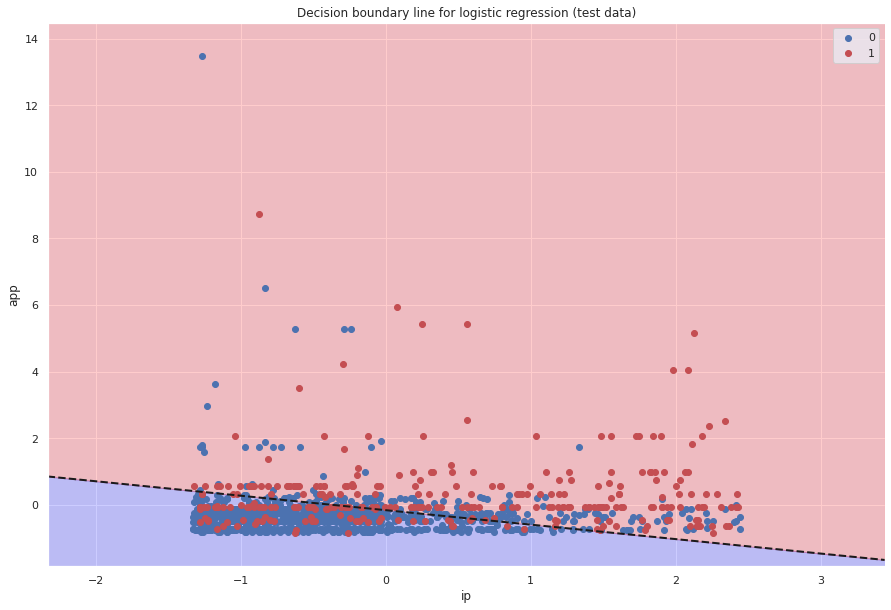

In [ ]:
# grab intercept and coefficient of linear regression model
b = lr.intercept_[0]
w1, w2 = lr.coef_.T

# Calculate the intercept and slope of the decision boundary line
c = -b/w2
m = -w1/w2

# Plot the classification with the decision boundary
xd = np.array([x_min, x_max])
yd = m * xd + c
plt.figure(figsize=(15,10))
plt.plot(xd, yd, 'k', lw=2, ls='--')
plt.fill_between(xd, yd, y_min, color='blue', alpha=0.2)
plt.fill_between(xd, yd, y_max, color='red', alpha=0.2)

# scatter plot of test set
for i, color in zip(range(2), 'bry'):
  idx = np.where(y_test == i)
  plt.scatter(X_test[idx, 0], X_test[idx, 1], c=color, label=y_test.iloc[i], cmap='bry')
plt.xlabel('ip')
plt.ylabel('app')
plt.title('Decision boundary line for logistic regression (test data)')
plt.legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

##### plot ROC

calling predict_proba of logistic regression model to get the probabilities of each instance belonging to each class:

In [ ]:
lr_prob = log_reg.predict_proba(X_test)

grabbing only probabilities of belonging to class 1:

In [ ]:
lr_prob = lr_prob[:, 1]

computing auc score:

In [ ]:
lr_auc = roc_auc_score(y_test, lr_prob)

In [ ]:
print('Logistic regression ROC AUC = %.3f' %(lr_auc))

Logistic regression ROC AUC = 0.832


now plotting ROC curve:

In [ ]:
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_prob)

Text(0.5, 1.0, 'ROC curve for logistic regression')

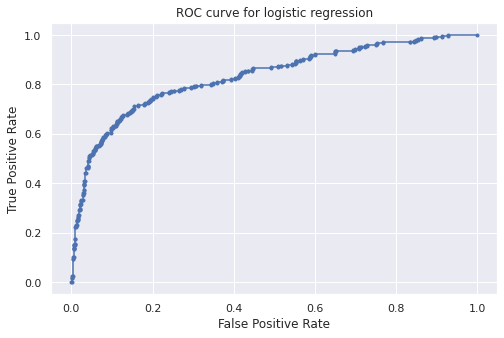

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(lr_fpr, lr_tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for logistic regression')

#### 2- Support Vector Machine (SVM)

##### cross validation

using GridSearchCV with validation set to find better values for some of the main parameters of the model:

In [ ]:
# experimenting some values for "C" and "gamma" parameters of SVM
svm_params = {'C': [0.1, 1], 'kernel': ['rbf'], 'gamma': [1, 0.1]}
svm_grid = GridSearchCV(SVC(), svm_params, refit=True, verbose=3)

In [ ]:
svm_grid.fit(X_val, y_val)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.812 total time=   0.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.804 total time=   0.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.820 total time=   0.3s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.859 total time=   0.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.812 total time=   0.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.812 total time=   0.3s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.803 total time=   0.3s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.832 total time=   0.3s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.854 total time=   0.3s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.827 total time=   0.3s
[CV 1/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.830 total time=   0.3s
[CV 2/5] END ..........C=1, gamma=1, kernel=rbf;,

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1], 'gamma': [1, 0.1], 'kernel': ['rbf']},
             verbose=3)

getting best parameters:

In [ ]:
svm_grid.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

##### the model

training the SVM model on train set with the best parameters found: <br>
(also setting probability to True so that I can call predict_proba later)

In [ ]:
svm = SVC(C=1, gamma=0.1, kernel='rbf', probability=True)

In [ ]:
svm.fit(X_train, y_train)

SVC(C=1, gamma=0.1, probability=True)

predicting labels for train set in order to find out accuracy on train set:

In [ ]:
train_preds = svm.predict(X_train)

printing classification report and confusion matrix and accuracy score for prediction on train set:

In [ ]:
print(classification_report(y_train, train_preds))
print()
print(confusion_matrix(y_train, train_preds))
print()
print('SVM train accuracy :', round(accuracy_score(y_train, train_preds), 2))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      3583
           1       0.87      0.82      0.85      3622

    accuracy                           0.85      7205
   macro avg       0.85      0.85      0.85      7205
weighted avg       0.85      0.85      0.85      7205


[[3158  425]
 [ 653 2969]]

SVM train accuracy : 0.85


now predicting labels for test set:

In [ ]:
test_preds = svm.predict(X_test)

printing classification report and confusion matrix and accuracy score for prediction on test set:

In [ ]:
print(classification_report(y_test, test_preds))
print()
print(confusion_matrix(y_test, test_preds))
print()
print('SVM test accuracy :', round(accuracy_score(y_test, test_preds), 2))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1303
           1       0.58      0.74      0.65       297

    accuracy                           0.85      1600
   macro avg       0.76      0.81      0.78      1600
weighted avg       0.87      0.85      0.86      1600


[[1143  160]
 [  78  219]]

SVM test accuracy : 0.85


##### plot decision boundary

defining 2 functions to use for plotting decision boundaries from now on:

In [ ]:
def make_meshgrid(x_min, x_max, y_min, y_max):
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    return xx, yy

def plot_contours(clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

(-1.8507788784364754, 14.480440494933074)

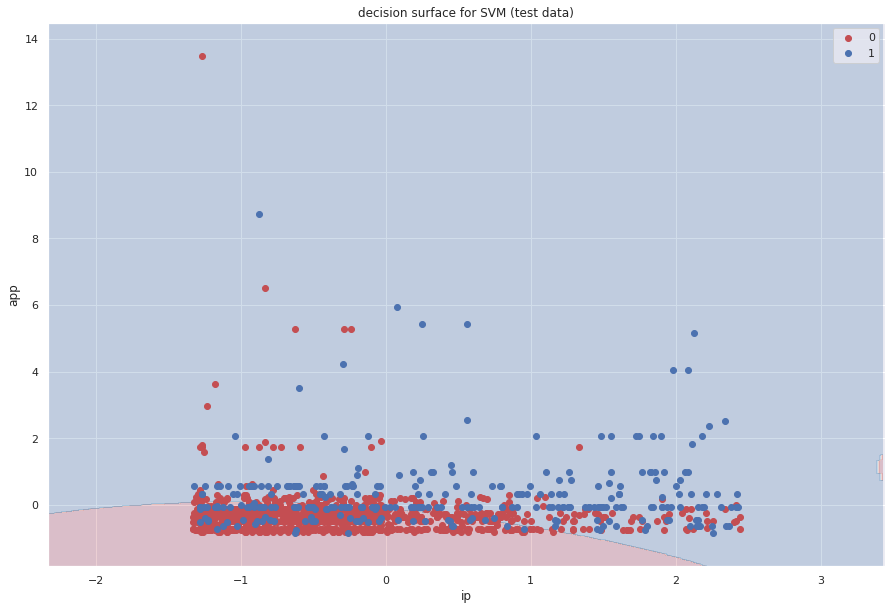

In [ ]:
# training a SVM model on 2 most important features of train set; "ip" and "app":
svm_model = SVC(C=1, gamma=0.1, kernel='rbf')
svm_clf = svm_model.fit(X_train[:, :2], y_train)

# Set up grid for plotting.
plt.figure(figsize=(15,10))
xx, yy = make_meshgrid(x_min, x_max, y_min, y_max)

# plot contour plot and scatter plot
plot_contours(svm_clf, xx, yy, cmap='RdBu', alpha=0.2)
for i, color in zip(range(2), 'rby'):
  idx = np.where(y_test == i)
  plt.scatter(X_test[idx, 0], X_test[idx, 1], c=color, label=y_test.iloc[i], cmap='RdBu')

plt.xlabel('ip')
plt.ylabel('app')
plt.title('decision surface for SVM (test data)')
plt.legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

##### plot ROC

calling predict_proba of SVM model and grabbing probabilities of belonging to class 1:

In [ ]:
svm_prob = svm.predict_proba(X_test)
svm_prob = svm_prob[:, 1]

printing auc score:

In [ ]:
svm_auc = roc_auc_score(y_test, svm_prob)
print('SVM ROC AUC = %.3f' %(svm_auc))

SVM ROC AUC = 0.871


now plotting ROC curve:

In [ ]:
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_prob)

Text(0.5, 1.0, 'ROC curve for SVM')

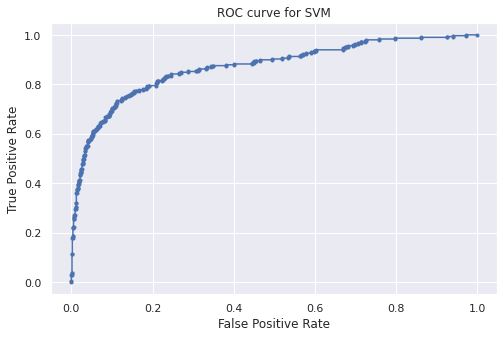

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(svm_fpr, svm_tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for SVM')

#### 3- k Nearest Neighbors

##### cross validation

In [ ]:
# experimenting some values for parameters "n_neighbors" of knn to find better parameters
knn_params = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, refit=True, verbose=5)

In [ ]:
# fit GridSearchCV object on validation set
knn_grid.fit(X_val, y_val)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5] END .....................n_neighbors=2;, score=0.817 total time=   0.0s
[CV 2/5] END .....................n_neighbors=2;, score=0.819 total time=   0.0s
[CV 3/5] END .....................n_neighbors=2;, score=0.814 total time=   0.0s
[CV 4/5] END .....................n_neighbors=2;, score=0.804 total time=   0.0s
[CV 5/5] END .....................n_neighbors=2;, score=0.815 total time=   0.0s
[CV 1/5] END .....................n_neighbors=3;, score=0.828 total time=   0.0s
[CV 2/5] END .....................n_neighbors=3;, score=0.809 total time=   0.1s
[CV 3/5] END .....................n_neighbors=3;, score=0.820 total time=   0.0s
[CV 4/5] END .....................n_neighbors=3;, score=0.827 total time=   0.0s
[CV 5/5] END .....................n_neighbors=3;, score=0.802 total time=   0.0s
[CV 1/5] END .....................n_neighbors=4;, score=0.820 total time=   0.1s
[CV 2/5] END .....................n_neighbors=4;

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]},
             verbose=5)

getting the best value for n_neighbors:

In [ ]:
knn_grid.best_params_

{'n_neighbors': 4}

##### the model

training the model on train set with 4 neighbors:

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

predicting labels for train set in order to find out accuracy on train set:

In [ ]:
train_preds = knn.predict(X_train)

printing classification report and confusion matrix and accuracy score for prediction on train set:

In [ ]:
print(classification_report(y_train, train_preds))
print()
print(confusion_matrix(y_train, train_preds))
print()
print('KNN train accuracy :', round(accuracy_score(y_train, train_preds), 2))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      3583
           1       0.95      0.87      0.91      3622

    accuracy                           0.91      7205
   macro avg       0.91      0.91      0.91      7205
weighted avg       0.91      0.91      0.91      7205


[[3419  164]
 [ 484 3138]]

KNN train accuracy : 0.91


predicting labels for test set:

In [ ]:
test_preds = knn.predict(X_test)

printing classification report and confusion matrix and accuracy score for prediction of model on test set:

In [ ]:
print(classification_report(y_test, test_preds))
print()
print(confusion_matrix(y_test, test_preds))
print()
print('KNN test accuracy :', round(accuracy_score(y_test, test_preds), 2))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1303
           1       0.63      0.68      0.65       297

    accuracy                           0.87      1600
   macro avg       0.78      0.79      0.78      1600
weighted avg       0.87      0.87      0.87      1600


[[1183  120]
 [  95  202]]

KNN test accuracy : 0.87


##### plot decision boundary

defining another function for plotting knn decision boundary:

In [ ]:
def plot_mesh(clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.pcolormesh(xx, yy, Z, **params)
    return out

(-1.8507788784364754, 14.480440494933074)

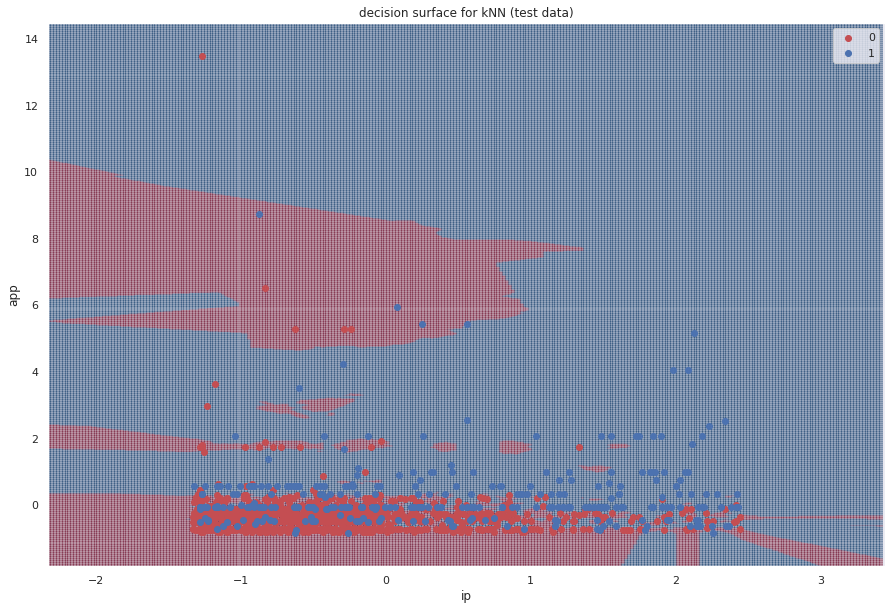

In [ ]:
# training another knn model on 2 most important features of train set; "ip" and "app"
knn_model = KNeighborsClassifier(n_neighbors=4)
knn_clf = knn_model.fit(X_train[:, :2], y_train)

plt.figure(figsize=(15,10))
xx, yy = make_meshgrid(x_min, x_max, y_min, y_max)

# Plot the test data and the classification with the decision boundary
plot_mesh(knn_clf, xx, yy, cmap='RdBu', alpha=0.2)
for i, color in zip(range(2), 'rby'):
  idx = np.where(y_test == i)
  plt.scatter(X_test[idx, 0], X_test[idx, 1], c=color, label=y_test.iloc[i], cmap='RdBu')
plt.xlabel('ip')
plt.ylabel('app')
plt.title('decision surface for kNN (test data)')
plt.legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

##### plot ROC

In [ ]:
knn_prob = knn.predict_proba(X_test)
knn_prob = knn_prob[:, 1]

computing auc score:

In [ ]:
knn_auc = roc_auc_score(y_test, knn_prob)
print('KNN ROC AUC = %.3f' %(knn_auc))

KNN ROC AUC = 0.850


plotting ROC curve:

In [ ]:
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_prob)

Text(0.5, 1.0, 'ROC curve for KNN')

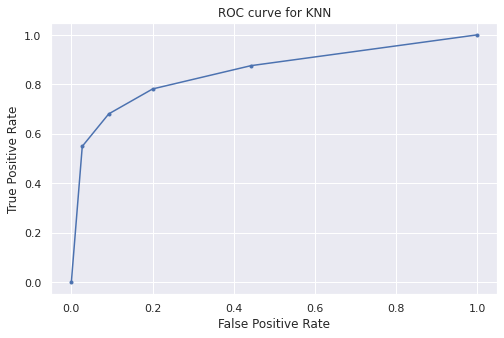

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(knn_fpr, knn_tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for KNN')

#### 4- Decision Tree

##### cross validation

using GridSearchCV with validation set to find better values for some of the main parameters of the model:

In [ ]:
# experimenting two values for parameter "criterion" of decision tree
dt_params = {'criterion': ['gini', 'entropy']}
dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_params, refit=True, verbose=5)

In [ ]:
dt_grid.fit(X_val, y_val)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ....................criterion=gini;, score=0.885 total time=   0.0s
[CV 2/5] END ....................criterion=gini;, score=0.913 total time=   0.0s
[CV 3/5] END ....................criterion=gini;, score=0.896 total time=   0.0s
[CV 4/5] END ....................criterion=gini;, score=0.885 total time=   0.0s
[CV 5/5] END ....................criterion=gini;, score=0.898 total time=   0.0s
[CV 1/5] END .................criterion=entropy;, score=0.895 total time=   0.0s
[CV 2/5] END .................criterion=entropy;, score=0.903 total time=   0.0s
[CV 3/5] END .................criterion=entropy;, score=0.905 total time=   0.0s
[CV 4/5] END .................criterion=entropy;, score=0.901 total time=   0.0s
[CV 5/5] END .................criterion=entropy;, score=0.891 total time=   0.0s


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy']}, verbose=5)

printing the best parameters found:

In [ ]:
dt_grid.best_params_

{'criterion': 'entropy'}

##### the model

training the decision tree model on train set with the best parameters found:

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

printing classification report and confusion matrix and accuracy score for prediction on train set:

In [ ]:
train_preds = dt.predict(X_train)
print(classification_report(y_train, train_preds))
print()
print(confusion_matrix(y_train, train_preds))
print()
print('Decision tree train accuracy :', round(accuracy_score(y_train, train_preds), 2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3583
           1       1.00      1.00      1.00      3622

    accuracy                           1.00      7205
   macro avg       1.00      1.00      1.00      7205
weighted avg       1.00      1.00      1.00      7205


[[3583    0]
 [   0 3622]]

Decision tree train accuracy : 1.0


printing classification report and confusion matrix and accuracy score for prediction on test set:

In [ ]:
test_preds = dt.predict(X_test)
print(classification_report(y_test, test_preds))
print()
print(confusion_matrix(y_test, test_preds))
print()
print('Decision tree test accuracy :', round(accuracy_score(y_test, test_preds), 2))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      1303
           1       0.67      0.82      0.74       297

    accuracy                           0.89      1600
   macro avg       0.82      0.87      0.84      1600
weighted avg       0.91      0.89      0.90      1600


[[1184  119]
 [  52  245]]

Decision tree test accuracy : 0.89


##### plot decision boundary

plotting the dicision boundary of decision tree to see how it classifies test set:

(-1.8507788784364754, 14.480440494933074)

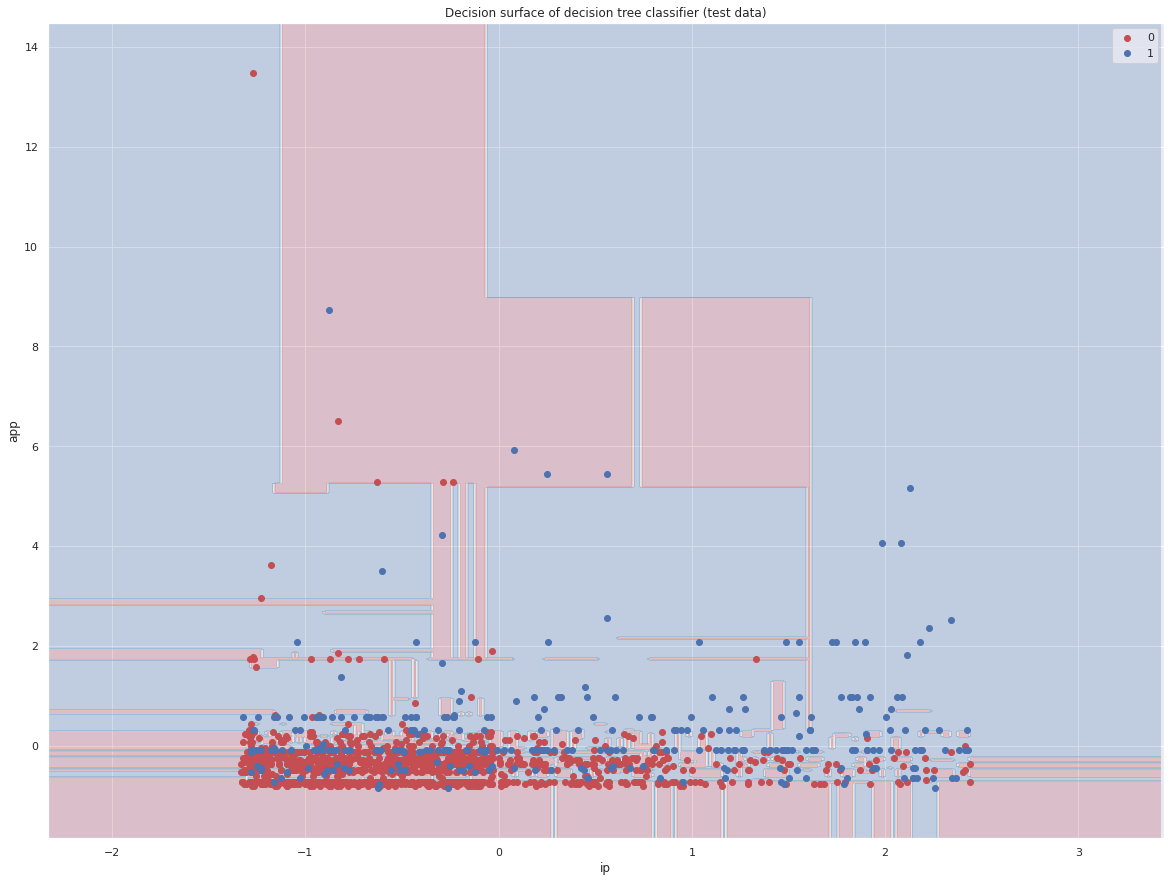

In [ ]:
# training another model on 2 most important features of train set; "ip" and "app"
dt_model = DecisionTreeClassifier(criterion='entropy')
dt_clf = dt_model.fit(X_train[:, :2], y_train)

# set up of plot
plt.figure(figsize=(20,15))
xx, yy = make_meshgrid(x_min, x_max, y_min, y_max)

# Plot the classification with the decision boundary
plot_contours(dt_clf, xx, yy, cmap='RdBu', alpha=0.2)
for i, color in zip(range(2), 'rby'):
  idx = np.where(y_test == i)
  plt.scatter(X_test[idx, 0], X_test[idx, 1], c=color, label=y_test.iloc[i], cmap='RdBu')
plt.xlabel('ip')
plt.ylabel('app')
plt.title('Decision surface of decision tree classifier (test data)')
plt.legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

##### plot ROC

calling predict_proba of the model to get the probabilities of each instance belonging to each class and grabbing only probabilities of belonging to class 1:

In [ ]:
dt_prob = dt.predict_proba(X_test)
dt_prob = dt_prob[:, 1]

printing auc score:

In [ ]:
dt_auc = roc_auc_score(y_test, dt_prob)
print('Decision tree ROC AUC = %.3f' %(dt_auc))

Decision tree ROC AUC = 0.867


plotting ROC curve:

In [ ]:
# false positive rate and true positive rate
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_prob)

Text(0.5, 1.0, 'ROC curve for Decision tree')

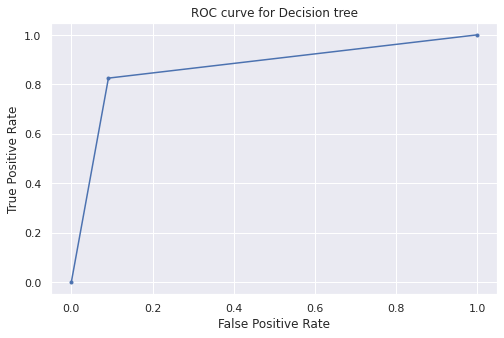

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(dt_fpr, dt_tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Decision tree')

#### 5- Random Forest

##### cross validation

experimenting some values for "n_estimators" parameter (number of trees) of random forest model and using GridSearchCV with validation set to find the best value among them:

In [ ]:
rf_params = {'n_estimators': [50, 100, 150, 200, 250, 300]}
rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, refit=True, verbose=5)

In [ ]:
rf_grid.fit(X_val, y_val)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...................n_estimators=50;, score=0.926 total time=   0.2s
[CV 2/5] END ...................n_estimators=50;, score=0.929 total time=   0.2s
[CV 3/5] END ...................n_estimators=50;, score=0.926 total time=   0.2s
[CV 4/5] END ...................n_estimators=50;, score=0.929 total time=   0.2s
[CV 5/5] END ...................n_estimators=50;, score=0.922 total time=   0.2s
[CV 1/5] END ..................n_estimators=100;, score=0.919 total time=   0.4s
[CV 2/5] END ..................n_estimators=100;, score=0.927 total time=   0.4s
[CV 3/5] END ..................n_estimators=100;, score=0.921 total time=   0.4s
[CV 4/5] END ..................n_estimators=100;, score=0.921 total time=   0.4s
[CV 5/5] END ..................n_estimators=100;, score=0.922 total time=   0.3s
[CV 1/5] END ..................n_estimators=150;, score=0.924 total time=   0.5s
[CV 2/5] END ..................n_estimators=150;,

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [50, 100, 150, 200, 250, 300]},
             verbose=5)

printing the best n_estimator found:

In [ ]:
rf_grid.best_params_

{'n_estimators': 200}

##### the model

training the random forest model on train set with the best value found for parameter:

In [ ]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

printing classification report and confusion matrix and accuracy score for prediction on train set:

In [ ]:
train_preds = rf.predict(X_train)
print(classification_report(y_train, train_preds))
print()
print(confusion_matrix(y_train, train_preds))
print()
print('Random forest train accuracy :', round(accuracy_score(y_train, train_preds), 2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3583
           1       1.00      1.00      1.00      3622

    accuracy                           1.00      7205
   macro avg       1.00      1.00      1.00      7205
weighted avg       1.00      1.00      1.00      7205


[[3583    0]
 [   0 3622]]

Random forest train accuracy : 1.0


printing classification report and confusion matrix and accuracy score for prediction on test set:

In [ ]:
test_preds = rf.predict(X_test)
print(classification_report(y_test, test_preds))
print()
print(confusion_matrix(y_test, test_preds))
print()
print('Random forest test accuracy :', round(accuracy_score(y_test, test_preds), 2))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1303
           1       0.87      0.83      0.85       297

    accuracy                           0.95      1600
   macro avg       0.92      0.90      0.91      1600
weighted avg       0.95      0.95      0.95      1600


[[1267   36]
 [  50  247]]

Random forest test accuracy : 0.95


##### plot decision boundary

(-1.8507788784364754, 14.480440494933074)

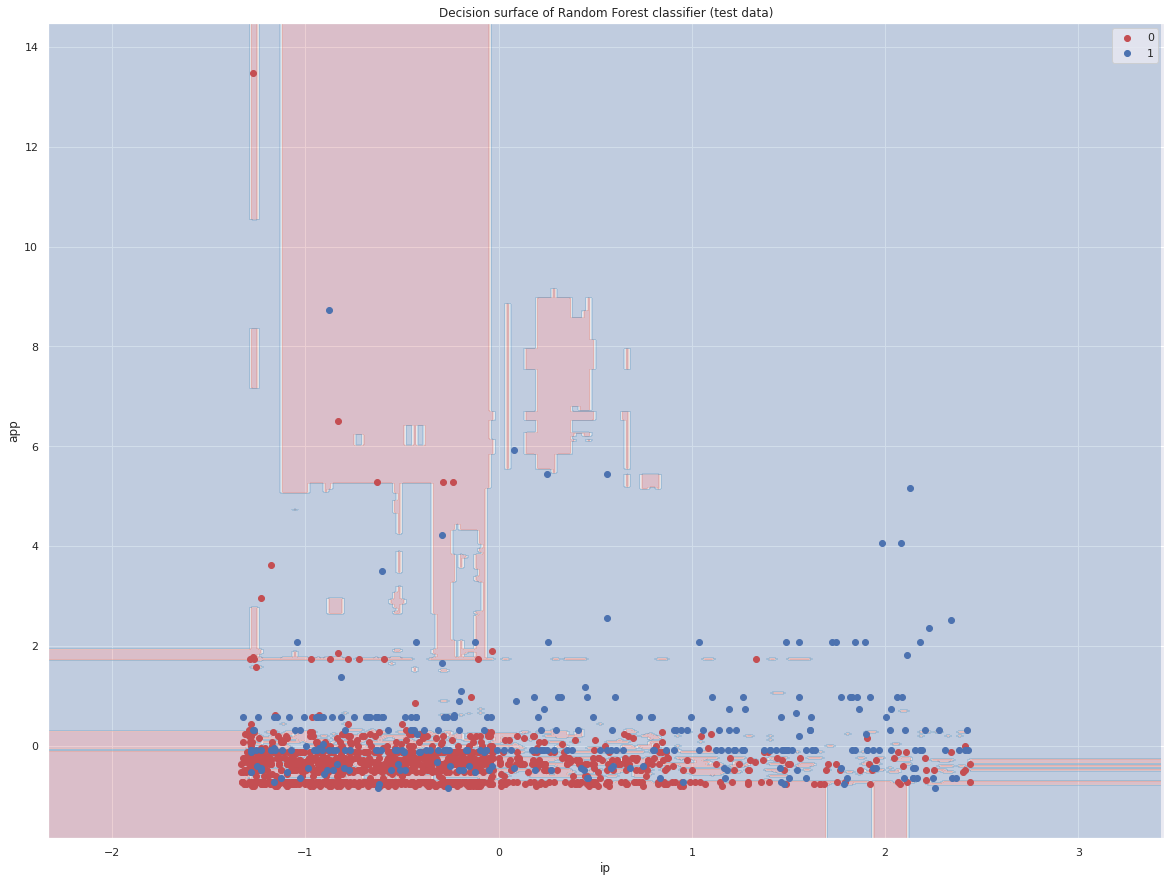

In [ ]:
# training a random forest model on 2 most important features of train set; "ip" and "app"
rf_model = RandomForestClassifier(n_estimators=200)
rf_clf = rf_model.fit(X_train[:, :2], y_train)

plt.figure(figsize=(20,15))
xx, yy = make_meshgrid(x_min, x_max, y_min, y_max)

# plot test data and classification boundaries
plot_contours(rf_clf, xx, yy, cmap='RdBu', alpha=0.2)
for i, color in zip(range(2), 'rby'):
  idx = np.where(y_test == i)
  plt.scatter(X_test[idx, 0], X_test[idx, 1], c=color, label=y_test.iloc[i], cmap='RdBu')
plt.xlabel('ip')
plt.ylabel('app')
plt.title('Decision surface of Random Forest classifier (test data)')
plt.legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

##### plot ROC

In [ ]:
rf_prob = rf.predict_proba(X_test)
rf_prob = rf_prob[:, 1]

In [ ]:
# print auc score
rf_auc = roc_auc_score(y_test, rf_prob)
print('Random forest ROC AUC = %.3f' %(rf_auc))

Random forest ROC AUC = 0.947


plotting ROC curve:

In [ ]:
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)

Text(0.5, 1.0, 'ROC curve for random forest')

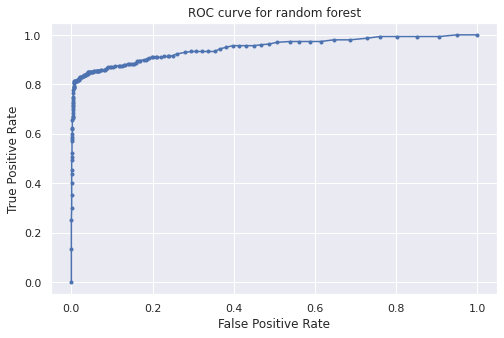

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(rf_fpr, rf_tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for random forest')

#### 6- Naive Bayes

##### the model

In [ ]:
# I used "GaussianNB" because there are real values in feature columns of dataset
# also I couldn't come up with parameters to experiment on with cross validation so I dropped that part
bayes = GaussianNB()

# fit naive bayes model on train set
bayes.fit(X_train, y_train)

GaussianNB()

predicting labels for train set and printing classification report and confusion matrix and accuracy score for prediction on train set:

In [ ]:
train_preds = bayes.predict(X_train)
print(classification_report(y_train, train_preds))
print()
print(confusion_matrix(y_train, train_preds))
print()
print('Naive Bayes train accuracy :', round(accuracy_score(y_train, train_preds), 2))

              precision    recall  f1-score   support

           0       0.79      0.68      0.73      3583
           1       0.72      0.82      0.77      3622

    accuracy                           0.75      7205
   macro avg       0.76      0.75      0.75      7205
weighted avg       0.76      0.75      0.75      7205


[[2444 1139]
 [ 637 2985]]

Naive Bayes train accuracy : 0.75


predicting labels for test set and printing classification report and confusion matrix and accuracy score for prediction on test set:

In [ ]:
test_preds = bayes.predict(X_test)
print(classification_report(y_test, test_preds))
print()
print(confusion_matrix(y_test, test_preds))
print()
print('Naive Bayes test accuracy :', round(accuracy_score(y_test, test_preds), 2))

              precision    recall  f1-score   support

           0       0.92      0.68      0.78      1303
           1       0.34      0.73      0.47       297

    accuracy                           0.69      1600
   macro avg       0.63      0.71      0.62      1600
weighted avg       0.81      0.69      0.72      1600


[[881 422]
 [ 79 218]]

Naive Bayes test accuracy : 0.69


##### plot decision boundary

training another naive bayes model on 2 most important features of train set; "ip" and "app":

(-1.8507788784364754, 14.480440494933074)

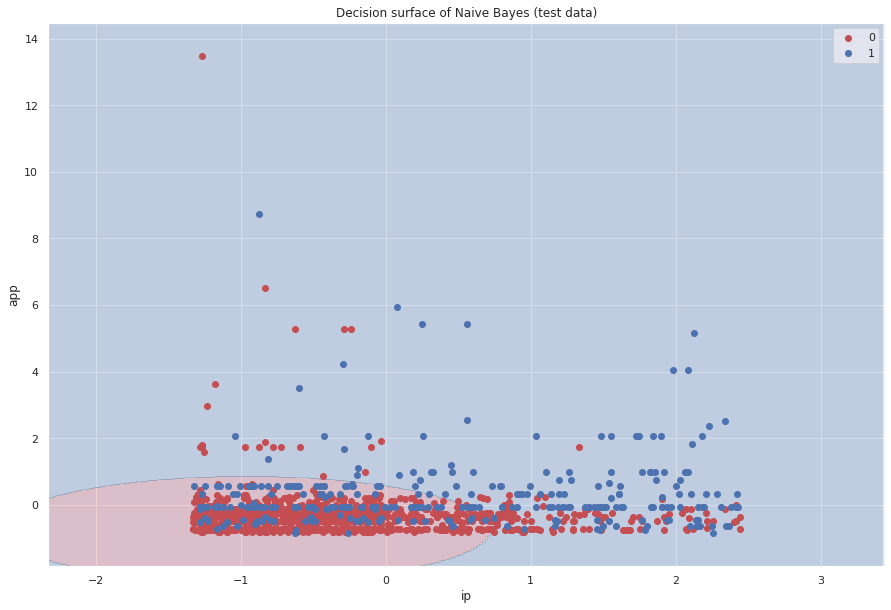

In [ ]:
# fit the model
nb_model = GaussianNB()
nb_clf = nb_model.fit(X_train[:, :2], y_train)

plt.figure(figsize=(15,10))
xx, yy = make_meshgrid(x_min, x_max, y_min, y_max)

# plot the classification with the decision boundary and scatter plot of test set
plot_contours(nb_clf, xx, yy, cmap='RdBu', alpha=0.2)
for i, color in zip(range(2), 'rby'):
  idx = np.where(y_test == i)
  plt.scatter(X_test[idx, 0], X_test[idx, 1], c=color, label=y_test.iloc[i], cmap='RdBu')
plt.xlabel('ip')
plt.ylabel('app')
plt.title('Decision surface of Naive Bayes (test data)')
plt.legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

##### plot ROC

In [ ]:
bayes_prob = bayes.predict_proba(X_test)
bayes_prob = bayes_prob[:, 1]

computing auc score:

In [ ]:
bayes_auc = roc_auc_score(y_test, bayes_prob)
print('Naive Bayes ROC AUC = %.3f' %(bayes_auc))

Naive Bayes ROC AUC = 0.780


now plotting ROC curve:

In [ ]:
b_fpr, b_tpr, _ = roc_curve(y_test, bayes_prob)

Text(0.5, 1.0, 'ROC curve for Naive Bayes')

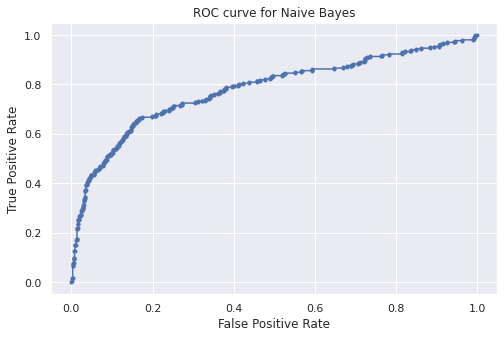

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(b_fpr, b_tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Naive Bayes')